### this segmentation is a sub-segmentation of the original segmentations provided by the dataset

1) create a dataset of syllable waveforms for each isolation segment

2) get segmented times for each syllable in that segment

3) create a new dataframe with the isolated syllables

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation
from vocalseg.dynamic_thresholding import plot_segmented_spec, plot_segmentations
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import pandas as pd
from datetime import datetime


In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [5]:
DATASET_ID = 'BIRD_DB_Toxostoma_redivivum'

In [31]:
# create a unique datetime identifier for the files output by this notebook
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

'2019-11-14_10-36-28'

In [7]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [8]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [9]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=10000,
    butter_lowcut = 500,
    butter_highcut = 10000,
    ref_level_db = 20,
    min_level_db = -25,
    mask_spec = True,
    win_length_ms = 5,
    hop_length_ms = 0.5,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10}
)

In [10]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s


[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    3.1s finished


In [11]:
dataset.sample_json

OrderedDict([('TrackName', 'tSMM0212-28'),
             ('type_of_device', 'single microphone'),
             ('configuration', 'MOC2012'),
             ('microphone',
              'Sennheiser omnidirectional with Telinga parabolic reflector'),
             ('recorder', 'Marantz PMD650'),
             ('sample_rate', 44.0),
             ('Recordist_first_name', 'Martin'),
             ('Recordist_last_name', 'Cody'),
             ('recording_date', '2012-02-10_00-00-00'),
             ('recording_time', '08:42:00'),
             ('recording_length', '00:04:57'),
             ('Audio_file',
              'http://taylor0.biology.ucla.edu/birdDBQuery/Files/Tracks/2012/Feb/TRK28-2-12.WAV'),
             ('SubjectName', 'CATH-TLR9'),
             ('subject_importance', 'Primary subject'),
             ('quality_rating', 3.0),
             ('Species_short_name', 'CATH'),
             ('Subject_species', 'California Thrasher'),
             ('sex', 'Unkown sex'),
             ('age_class', '

In [12]:
len(dataset.data_files)

92

#### Create dataset based upon JSON

In [13]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [14]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=["labels"],
            unit="syllables",
            dict_features_to_retain = [],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.3s


[Parallel(n_jobs=-1)]: Done  55 out of  92 | elapsed:    3.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  65 out of  92 | elapsed:    3.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  75 out of  92 | elapsed:    3.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  85 out of  92 | elapsed:    3.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    3.7s finished


15328

In [15]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,key
0,0.114615,0.182918,aln,CATH-TLR9,0,2012-02-10_08-42-00-000000
1,0.430220,0.710496,alk,CATH-TLR9,0,2012-02-10_08-42-00-000000
2,1.021390,1.063785,alo,CATH-TLR9,0,2012-02-10_08-42-00-000000


In [16]:
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation
from vocalseg.dynamic_thresholding import plot_segmented_spec, plot_segmentations
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec
import warnings
warnings.filterwarnings('ignore')

#### Save audio df for each context since this is a big dataset

In [17]:
iters = [[row.indv, row.key, row.start_time, row.end_time, row.labels] for idx, row in tqdm(syllable_df.iterrows(), total = len(syllable_df))]

In [18]:
n_fft=1024
hop_length_ms=0.5
win_length_ms=8
ref_level_db=20
pre=0.97
min_level_db=-40
silence_threshold = 0.01
min_silence_for_spec=0.001
max_vocal_for_spec=2.0,
min_syllable_length_s = 0.025
spectral_range = [500, 8000]

In [19]:
syllable_df[:2]

,start_time,end_time,labels,indv,indvi,key
0,0.114615,0.182918,aln,CATH-TLR9,0,2012-02-10_08-42-00-000000
1,0.430220,0.710496,alk,CATH-TLR9,0,2012-02-10_08-42-00-000000


In [20]:
from avgn.utils.audio import int16_to_float32
from avgn.signalprocessing.filtering import butter_bandpass_filter
import librosa

In [21]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,key
0,0.114615,0.182918,aln,CATH-TLR9,0,2012-02-10_08-42-00-000000
1,0.430220,0.710496,alk,CATH-TLR9,0,2012-02-10_08-42-00-000000
2,1.021390,1.063785,alo,CATH-TLR9,0,2012-02-10_08-42-00-000000


In [22]:
db_delta = 5

In [32]:
butter_lowcut = 500
butter_highcut = 20000
def segment_spec_custom(indv, key, start_time, end_time, context, json_dict, segi= 1,  pad = 0.025, save=False, plot=False):
    # load wav
    wav_loc = dataset.data_files[key].data['wav_loc']
    duration = end_time - start_time
    data, rate = librosa.core.load(wav_loc, sr=None, offset = start_time - pad, duration = duration + pad*2)
    
    # filter data
    data = butter_bandpass_filter(data, butter_lowcut, butter_highcut, rate)
    
    # segment
    results = dynamic_threshold_segmentation(
        data,
        rate,
        n_fft=n_fft,
        hop_length_ms=hop_length_ms,
        win_length_ms=win_length_ms,
        min_level_db_floor=20,
        db_delta=db_delta,
        ref_level_db=ref_level_db,
        pre=pre,
        
        min_silence_for_spec=min_silence_for_spec,
        max_vocal_for_spec=max_vocal_for_spec,
        min_level_db=min_level_db,
        silence_threshold=silence_threshold,
        verbose=False,
        min_syllable_length_s=min_syllable_length_s,
        spectral_range=spectral_range,
    )
    
    if results is None:
        return
    
    if plot:
        plot_segmentations(
            results["spec"],
            results["vocal_envelope"],
            results["onsets"],
            results["offsets"],
            hop_length_ms,
            rate,
            figsize=(10, 5)
        )
        plt.show()
    
    # save the results
    json_out = DATA_DIR / "processed" / (DATASET_ID + "_segmented") / DT_ID / "JSON" / (
        key + '_' + str(segi) + ".JSON"
    )
    json_dict['label'] = context
    json_dict["indvs"][indv]["syllables"] = {
        "start_times": NoIndent(list(results["onsets"] + start_time - pad)),
        "end_times": NoIndent(list(results["offsets"] + start_time - pad)),
    }

    json_txt = json.dumps(json_dict, cls=NoIndentEncoder, indent=2)
    # save json
    if save:
        ensure_dir(json_out.as_posix())
        print(json_txt, file=open(json_out.as_posix(), "w"))

    #print(json_txt)

In [33]:
import joblib
from avgn.utils.json import NoIndent, NoIndentEncoder

In [34]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,key
0,0.114615,0.182918,aln,CATH-TLR9,0,2012-02-10_08-42-00-000000
1,0.430220,0.710496,alk,CATH-TLR9,0,2012-02-10_08-42-00-000000
2,1.021390,1.063785,alo,CATH-TLR9,0,2012-02-10_08-42-00-000000


In [35]:
indv, key, start_time, end_time, context = iters[0]
json_dict = dataset.data_files[key].data.copy()

In [36]:
wav_loc = dataset.data_files[key].data['wav_loc']
duration = end_time - start_time
data, rate = librosa.core.load(wav_loc, sr=None, offset = start_time, duration = duration)

# filter data
data = butter_bandpass_filter(data, butter_lowcut, butter_highcut, rate)

# segment
"""results = dynamic_threshold_segmentation(
    data,
    rate,
    n_fft=n_fft,
    hop_length_ms=hop_length_ms,
    win_length_ms=win_length_ms,
    min_level_db_floor=20,
    db_delta=db_delta,
    ref_level_db=ref_level_db,
    pre=pre,

    min_silence_for_spec=min_silence_for_spec,
    max_vocal_for_spec=max_vocal_for_spec,
    min_level_db=min_level_db,
    silence_threshold=silence_threshold,
    verbose=False,
    min_syllable_length_s=min_syllable_length_s,
    spectral_range=spectral_range,
)"""

'results = dynamic_threshold_segmentation(\n    data,\n    rate,\n    n_fft=n_fft,\n    hop_length_ms=hop_length_ms,\n    win_length_ms=win_length_ms,\n    min_level_db_floor=20,\n    db_delta=db_delta,\n    ref_level_db=ref_level_db,\n    pre=pre,\n\n    min_silence_for_spec=min_silence_for_spec,\n    max_vocal_for_spec=max_vocal_for_spec,\n    min_level_db=min_level_db,\n    silence_threshold=silence_threshold,\n    verbose=False,\n    min_syllable_length_s=min_syllable_length_s,\n    spectral_range=spectral_range,\n)'

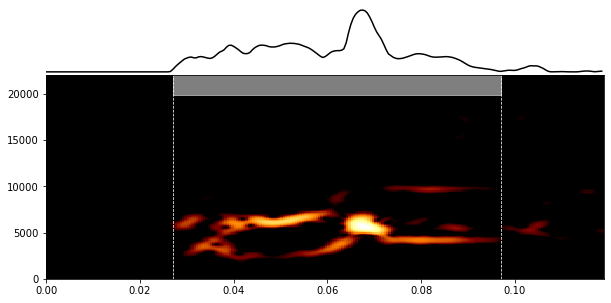

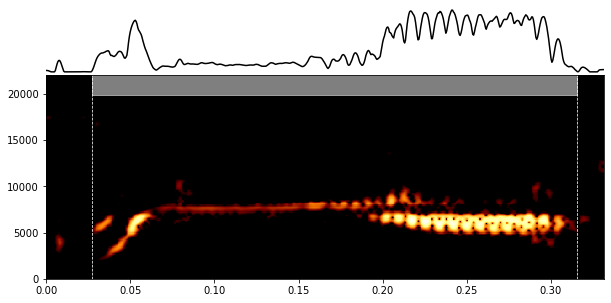

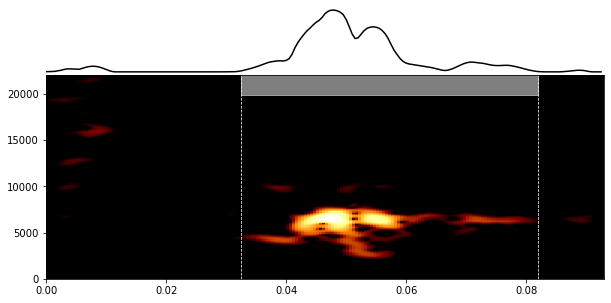

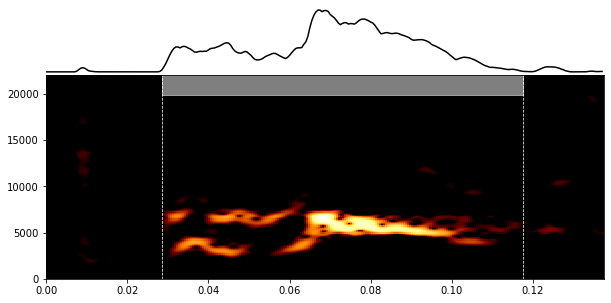

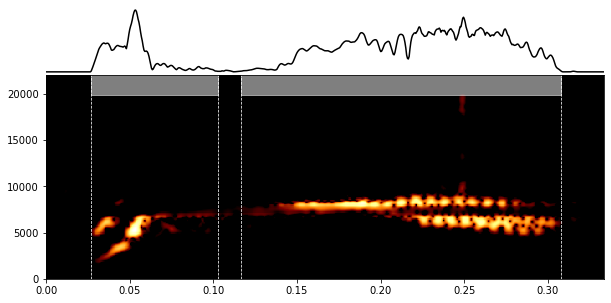

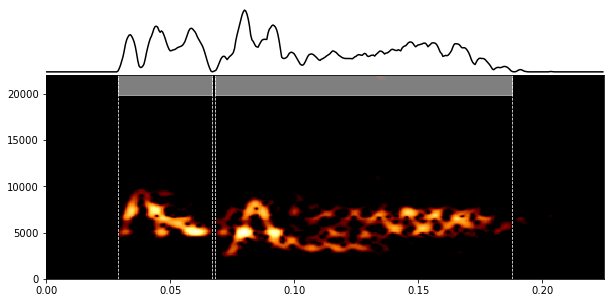

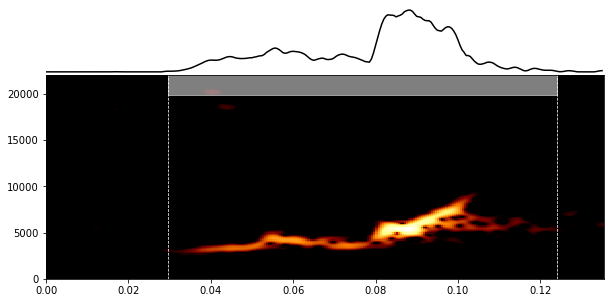

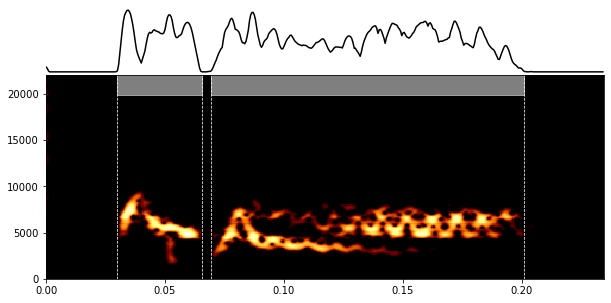

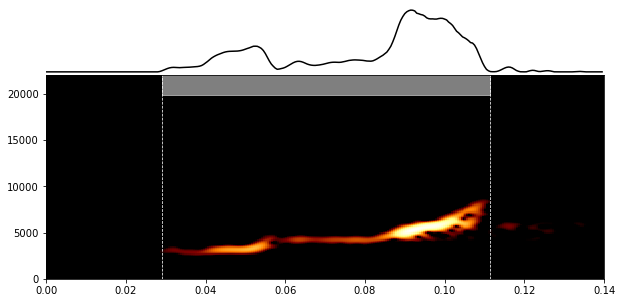

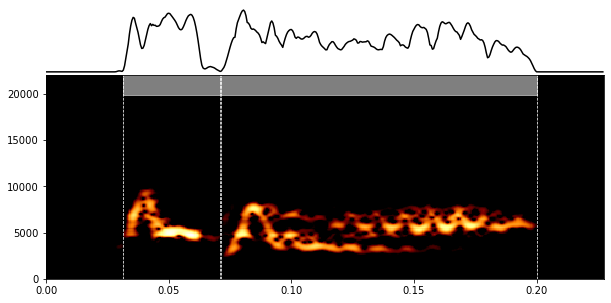

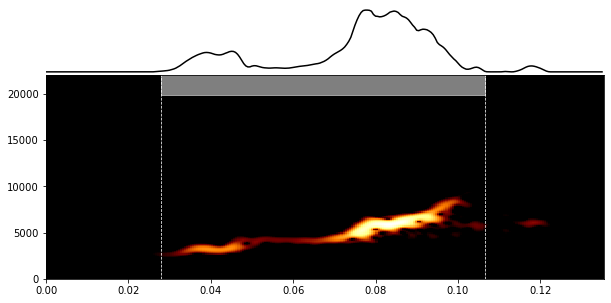

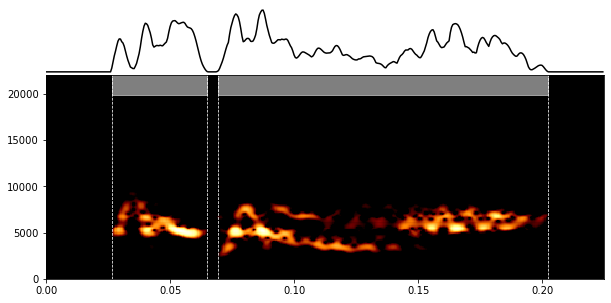

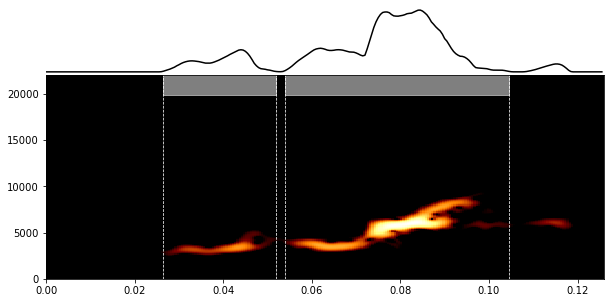

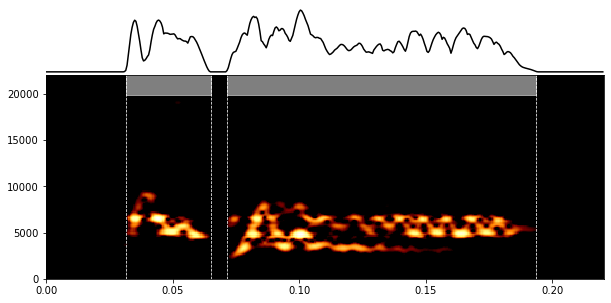

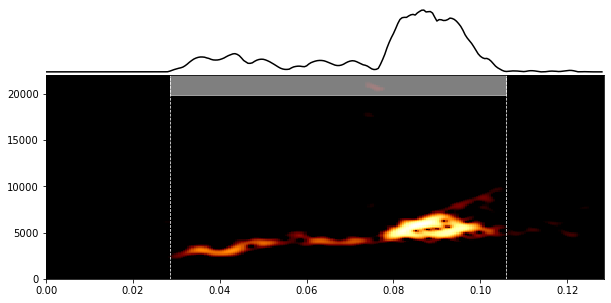

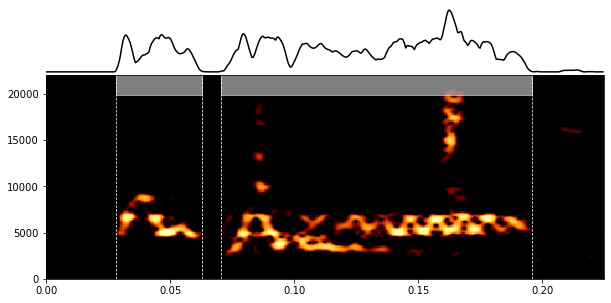

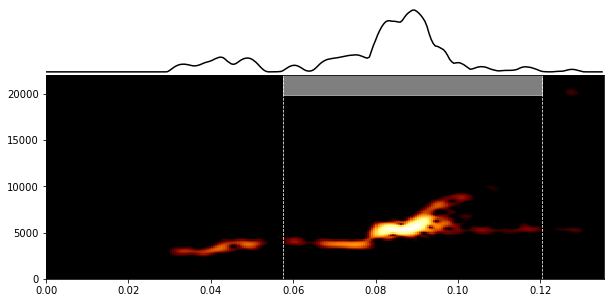

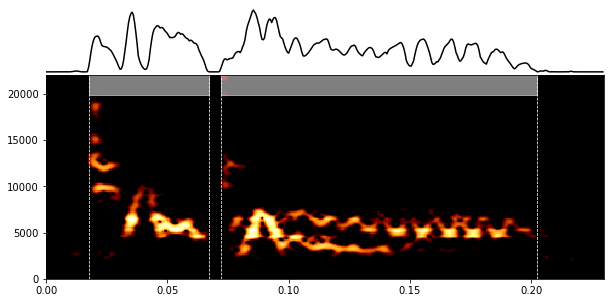

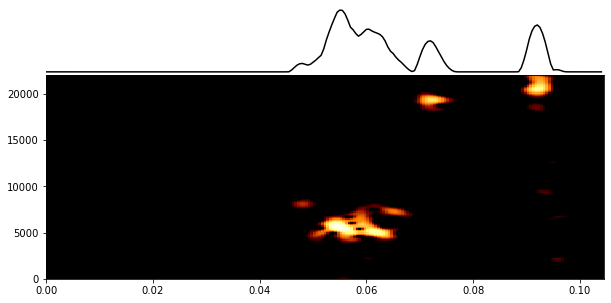

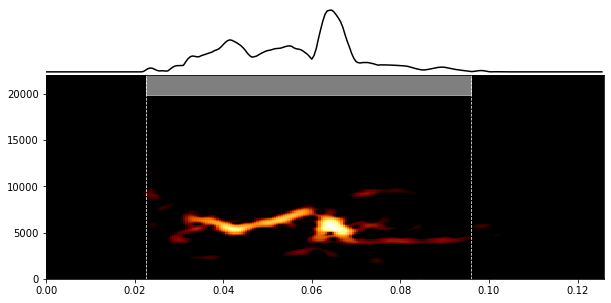

In [37]:
import warnings
warnings.filterwarnings("ignore")

nex = 20
joblib.Parallel(n_jobs=1, verbose=0)(
            joblib.delayed(segment_spec_custom)( indv, key, start_time, end_time, context, dataset.data_files[key].data.copy(), plot=True) 
                 for indv, key, start_time, end_time, context in tqdm(iters[:nex])
        );

In [38]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,key
0,0.114615,0.182918,aln,CATH-TLR9,0,2012-02-10_08-42-00-000000
1,0.430220,0.710496,alk,CATH-TLR9,0,2012-02-10_08-42-00-000000
2,1.021390,1.063785,alo,CATH-TLR9,0,2012-02-10_08-42-00-000000


In [39]:
nex = -1
n_jobs = 1
joblib.Parallel(n_jobs=n_jobs, verbose=11)(
    joblib.delayed(segment_spec_custom)(indv, key, start_time, end_time,
                                        context, dataset.data_files[key].data.copy(), segi=segi, save=True, plot=False)
    for segi, (indv, key, start_time, end_time, context) in enumerate(tqdm(iters[:nex]))
);

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s


[Parallel(n_jobs=1)]: Done 15327 out of 15327 | elapsed:  4.4min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,